In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import wandb
from tqdm.notebook import tqdm_notebook as tqdm

from dataclasses import dataclass

from src import LinregDataset, save, set_seed, train, evaluate
from src.transformer import LoopedTransformer
from src.transformer.rebased import LoopedTransformer as ReBasedLooped

In [2]:
@dataclass
class Config:
    n_dims:       int = 4
    num_layers:   int = 1
    attn_heads:   int = 4
    hidden_dim:   int = 32
    mlp_hidden:   int = 128
    context:      int = 129
    mask_type:    str = 'causal'
    normalize_input: bool = True
    normalize_kernel: bool = False
    activation:   nn.Module = nn.GELU
    
def get_config(name, n_dims):
    models = {
        'default': (Config(
            n_dims = n_dims, num_layers = 2,
            attn_heads = 4, hidden_dim = 64,
            mlp_hidden = 256, context = 129
        ), 1e-3, 64, 32),
        'rebased_inp': (Config(
            n_dims = n_dims, num_layers = 2,
            attn_heads = 4, hidden_dim = 64,
            mlp_hidden = 256, context = 129,
            normalize_input = True,
            normalize_kernel = False
        ), 1e-3, 64, 32),
        'rebased_ker': (Config(
            n_dims = n_dims, num_layers = 2,
            attn_heads = 4, hidden_dim = 64,
            mlp_hidden = 256, context = 129,
            normalize_input = False,
            normalize_kernel = True
        ), 1e-3, 64, 32),
        'rebased_none': (Config(
            n_dims = n_dims, num_layers = 2,
            attn_heads = 4, hidden_dim = 64,
            mlp_hidden = 256, context = 129,
            normalize_input = False,
            normalize_kernel = False
        ), 1e-3, 64, 32),
    }
    return models[name]

In [3]:
sum([p.numel() for p in LoopedTransformer(get_config('default', 4)[0]).parameters()])

108804

In [4]:
sum([p.numel() for p in ReBasedLooped(get_config('rebased_inp', 4)[0]).parameters()])

109060

## Тестируем оверфит на один батч

In [3]:
n_dims = 4
mean, std = 0, 1

train_loader = DataLoader(LinregDataset(
    n_dims = n_dims, n_points = 64 + 1,
    mean = mean, std = std, random = True,
    total = 32 * 10, device = 'cuda',
), batch_size = 32)

x, y = next(iter(train_loader))

  0%|          | 0/1000 [00:00<?, ?it/s]

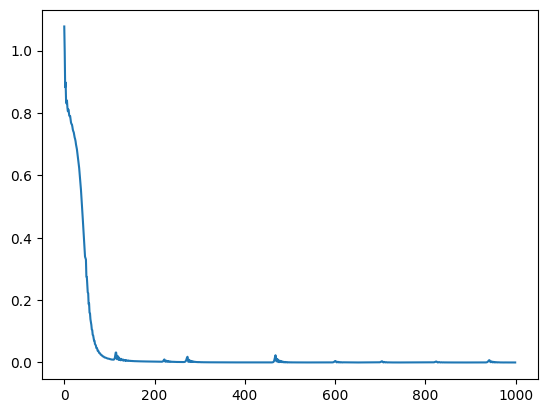

In [5]:
from torch.optim import Adam
import matplotlib.pyplot as plt

config, lr, _, _ = get_config('rebased_ker', 4)
model = ReBasedLooped(config).to('cuda')

optimizer = Adam(model.parameters(), lr=lr)

history = []
for i in tqdm(range(1000)):
    optimizer.zero_grad()

    preds = model(x[:, :-1], b = 2)
    preds = torch.stack(preds)
    targs = torch.stack([y] * 2)
    
    # Сначала по токенам, затем по итерациям, затем по батчам
    loss = (targs - preds).square().mean(dim=2).mean(dim=0).mean()
    loss = loss / train_loader.dataset.n_dims
    
    loss.backward()
    optimizer.step()
    
    history.append(loss.item())

plt.plot(history)

## Тестируем скейлинг механизмов внимания на уменьшенных моделях

In [5]:
import time
from torch.optim import Adam

models = ['default', 'rebased_none', 'rebased_inp', 'rebased_ker']

device = 'cpu'

n_dims = 4
mean, std = 0, 1

ns = [1] + list(range(50, 2500, 50))

def test(device):
    results = {}

    for name in models:
        config, lr, _, _ = get_config(name, 4)
        res = []
        for n in tqdm(ns):
            config.num_layers = 1
            config.attn_heads = 2 
            config.hidden_dim = 16
            config.mlp_hidden = 64
            config.context = 2 * n + 1
            
            if name == 'default':
                model = LoopedTransformer(config).to(device)
            else:
                model = ReBasedLooped(config).to(device)

            optimizer = Adam(model.parameters(), lr=lr)
            
            loader = DataLoader(LinregDataset(
                n_dims = n_dims, n_points = n + 1,
                mean = mean, std = std, random = True,
                device = device
            ), batch_size = 1)
            
            x, y = next(iter(loader))
            
            start = time.time()
            model(x[:, :-1], b = 1)
            end = time.time()
            res.append(end - start)
            
        results[name] = res
        
    return results

cpu_results = test('cpu')
cuda_results = test('cuda')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

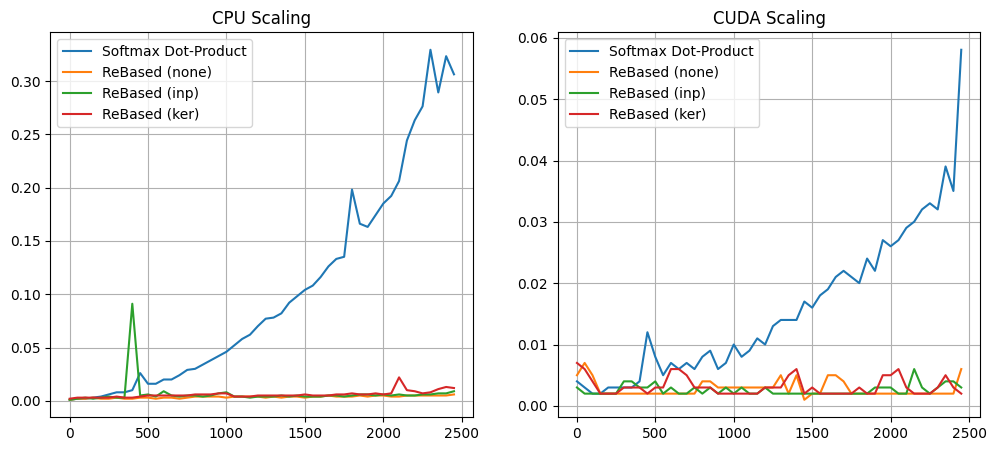

In [6]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(ns, cpu_results['default'], label = 'Softmax Dot-Product')
axs[0].plot(ns, cpu_results['rebased_none'], label = 'ReBased (none)')
axs[0].plot(ns, cpu_results['rebased_inp'], label = 'ReBased (inp)')
axs[0].plot(ns, cpu_results['rebased_ker'], label = 'ReBased (ker)')
axs[0].grid()
axs[0].legend()
axs[0].title.set_text('CPU Scaling')

axs[1].plot(ns, cuda_results['default'], label = 'Softmax Dot-Product')
axs[1].plot(ns, cuda_results['rebased_none'], label = 'ReBased (none)')
axs[1].plot(ns, cuda_results['rebased_inp'], label = 'ReBased (inp)')
axs[1].plot(ns, cuda_results['rebased_ker'], label = 'ReBased (ker)')
axs[1].grid()
axs[1].legend()
axs[1].title.set_text('CUDA Scaling')

plt.show()

## Тренируем модели

In [3]:
from torch.optim import Adam
from itertools import product

n_dims = 4
mean, std = 0, 1

seeds = [42, 451, 1984]
models = ['default', 'rebased_none', 'rebased_inp', 'rebased_ker']
bs = [1, 5]

runs = []
for model, bs, seed in product(models, bs, seeds):
    runs.append((model, bs, seed))

device = 'cuda' if torch.cuda.is_available() else 'cpu'

extrp_bs = [1, 5, 10, 15]

for (name, b, seed) in runs:

    config, lr, train_bsize, test_bsize = get_config(name, n_dims)
    n_points = 64 + 1

    train_loader = DataLoader(LinregDataset(
        n_dims = n_dims, n_points = n_points,
        mean = mean, std = std, random = True,
        device = device
    ), batch_size = train_bsize)
    test_loader = DataLoader(LinregDataset(
        n_dims = n_dims, n_points = n_points,
        mean = mean, std = std, random = True,
        total = test_bsize * 25, device = device
    ), batch_size = test_bsize)

    set_seed(seed)

    if name == 'default':
        model = LoopedTransformer(config).to(device)
    else:
        model = ReBasedLooped(config).to(device)
    optimizer = Adam(model.parameters(), lr=lr)

    run_name = f'{name}_{b}_{seed}'
    run = wandb.init(
        project = 'Looped Transformer',
        name = run_name,
        config = {
            'name': f'exp6_{name}_{b}',
            'experiment': 6,
            'model': name,
            'b': b,
            'train batch size': train_bsize,
            'test batch size': test_bsize,
            'lr': lr,
            'seed': seed,
            'N': n_points - 1,
        }
    )

    loss_history, eval_history = train(
        model, train_loader, test_loader, optimizer,
        steps = 3500, b = b, run = run, log_every = 35
    )

    extrapolation = []
    for bi in extrp_bs:
        result = evaluate(test_loader, model, bi)
        extrapolation.append(result)
        print(f'b = {bi} --- loss = {result:.5f}')
        run.log({'b': bi, 'MSE': result})
    
    run.finish()
    
    save(
        name = run_name, 
        model = model,
        loss = loss_history, 
        eval = eval_history, 
        extr = extrapolation,
        path = './results/experiment 6'
    )

    torch.cuda.empty_cache()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: daniillaptev. Use `wandb login --relogin` to force relogin


  0%|          | 0/3500 [00:00<?, ?it/s]

b = 1 --- loss = 0.48449
b = 5 --- loss = 3.79484
b = 10 --- loss = 13.31430
b = 15 --- loss = 25.80978


Eval Loss,██▇▄▁▁
MSE,▁▂▅█
Train Loss,▆▇▅▆█▆▆▆▅█▄▅▆▆▄▇▆▆▃▄▅▅▅▄▃▂▃▃▃▃▂▂▂▂▂▁▃▁▁▂
b,▁▃▅█
Eval Loss,0.55708
MSE,25.80978
Train Loss,0.59454
b,15


  0%|          | 0/3500 [00:00<?, ?it/s]

b = 1 --- loss = 0.72687
b = 5 --- loss = 1.34508
b = 10 --- loss = 2.63163
b = 15 --- loss = 5.31624


Eval Loss,██▃▄▁▁
MSE,▁▂▄█
Train Loss,█▄▅▅▅▅▆▆▆▆█▆█▅▂▃▄▄▅▃▁▄▂▃▆▃▄▁▁▁▄▂▃▃▁▁▂▃▃▃
b,▁▃▅█
Eval Loss,0.75798
MSE,5.31624
Train Loss,0.76661
b,15


  0%|          | 0/3500 [00:00<?, ?it/s]

b = 1 --- loss = 0.62324
b = 5 --- loss = 1.46983
b = 10 --- loss = 2.01843
b = 15 --- loss = 2.81078


Eval Loss,█▆▃▄▁▂
MSE,▁▄▅█
Train Loss,█▇▅▆▅▅▅▅▇▅▆▆▆▇▃▄▃▃▄▃▄▃▃▃▄▃▅▃▄▄▄▃▄▃▃▃▄▃▃▁
b,▁▃▅█
Eval Loss,0.7001
MSE,2.81078
Train Loss,0.52154
b,15


  0%|          | 0/3500 [00:00<?, ?it/s]

b = 1 --- loss = 0.04805
b = 5 --- loss = 0.01558
b = 10 --- loss = 0.01448
b = 15 --- loss = 0.02831


Eval Loss,█▅▃▁▁▁
MSE,█▁▁▄
Train Loss,█▄▄▄▄▄▄▄▄▄▃▃▄▄▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
b,▁▃▅█
Eval Loss,0.01633
MSE,0.02831
Train Loss,0.0708
b,15


  0%|          | 0/3500 [00:00<?, ?it/s]

b = 1 --- loss = 0.06761
b = 5 --- loss = 0.02007
b = 10 --- loss = 0.01433
b = 15 --- loss = 0.01667


Eval Loss,█▅▁▁▁▁
MSE,█▂▁▁
Train Loss,█▃▄▄▄▄▄▄▄▄▄▄▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
b,▁▃▅█
Eval Loss,0.0191
MSE,0.01667
Train Loss,0.0579
b,15


  0%|          | 0/3500 [00:00<?, ?it/s]

b = 1 --- loss = 0.05310
b = 5 --- loss = 0.01622
b = 10 --- loss = 0.01637
b = 15 --- loss = 0.03666


Eval Loss,█▄▁▁▁▁
MSE,█▁▁▅
Train Loss,█▃▃▃▃▃▃▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
b,▁▃▅█
Eval Loss,0.01678
MSE,0.03666
Train Loss,0.0498
b,15


  0%|          | 0/3500 [00:00<?, ?it/s]

b = 1 --- loss = 0.09013
b = 5 --- loss = 1.46952
b = 10 --- loss = 3.74170
b = 15 --- loss = 7.58134


Eval Loss,█▆▂▁▁▁
MSE,▁▂▄█
Train Loss,▇▇▇▆▅█▇▆▆▆▆▆▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
b,▁▃▅█
Eval Loss,0.07472
MSE,7.58134
Train Loss,0.14918
b,15


  0%|          | 0/3500 [00:00<?, ?it/s]

b = 1 --- loss = 0.11019
b = 5 --- loss = 1.30646
b = 10 --- loss = 5.85288
b = 15 --- loss = 19.27801


Eval Loss,██▃▁▁▁
MSE,▁▁▃█
Train Loss,██▇▇██▇▆▇▇█▇▆▆▅▄▃▂▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
b,▁▃▅█
Eval Loss,0.12641
MSE,19.27801
Train Loss,0.1698
b,15


  0%|          | 0/3500 [00:00<?, ?it/s]

b = 1 --- loss = 0.06995
b = 5 --- loss = 1.58813
b = 10 --- loss = 3.92843
b = 15 --- loss = 6.85585


Eval Loss,█▇▅▁▁▁
MSE,▁▃▅█
Train Loss,███▆▇▇▆▇██▇█▇▇▅▅▅▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
b,▁▃▅█
Eval Loss,0.077
MSE,6.85585
Train Loss,0.16118
b,15


  0%|          | 0/3500 [00:00<?, ?it/s]

b = 1 --- loss = 0.12444
b = 5 --- loss = 0.04502
b = 10 --- loss = 0.04081
b = 15 --- loss = 0.07527


Eval Loss,█▄▄▃▁▁
MSE,█▁▁▄
Train Loss,█▄▄▃▃▄▄▃▃▃▃▃▃▃▃▃▃▃▄▃▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
b,▁▃▅█
Eval Loss,0.04607
MSE,0.07527
Train Loss,0.0995
b,15


  0%|          | 0/3500 [00:00<?, ?it/s]

b = 1 --- loss = 0.23158
b = 5 --- loss = 0.13974
b = 10 --- loss = 0.11131
b = 15 --- loss = 0.13881


Eval Loss,█▇▇▅▂▁
MSE,█▃▁▃
Train Loss,█▄▄▄▄▄▄▃▄▃▄▃▃▄▃▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
b,▁▃▅█
Eval Loss,0.13671
MSE,0.13881
Train Loss,0.17485
b,15


  0%|          | 0/3500 [00:00<?, ?it/s]

b = 1 --- loss = 0.13670
b = 5 --- loss = 0.04981
b = 10 --- loss = 0.04036
b = 15 --- loss = 0.04304


Eval Loss,█▄▅▃▁▁
MSE,█▂▁▁
Train Loss,█▄▄▃▄▄▃▄▄▄▄▄▄▄▄▃▄▄▄▃▃▄▃▃▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁
b,▁▃▅█
Eval Loss,0.04783
MSE,0.04304
Train Loss,0.12445
b,15


  0%|          | 0/3500 [00:00<?, ?it/s]

b = 1 --- loss = 0.08802
b = 5 --- loss = 0.36361
b = 10 --- loss = 0.52652
b = 15 --- loss = 0.69021


Eval Loss,█▆▂▁▁▁
MSE,▁▄▆█
Train Loss,▇▇▇▆▅█▇▆▆▆▆▆▆▅▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
b,▁▃▅█
Eval Loss,0.09112
MSE,0.69021
Train Loss,0.14374
b,15


  0%|          | 0/3500 [00:00<?, ?it/s]

b = 1 --- loss = 0.12326
b = 5 --- loss = 0.63788
b = 10 --- loss = 0.99788
b = 15 --- loss = 1.43261


Eval Loss,██▄▁▁▁
MSE,▁▄▆█
Train Loss,██▇▇██▇▆▇▇█▇▇▇▆▆▃▃▂▁▁▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
b,▁▃▅█
Eval Loss,0.12312
MSE,1.43261
Train Loss,0.1777
b,15


  0%|          | 0/3500 [00:00<?, ?it/s]

b = 1 --- loss = 0.09194
b = 5 --- loss = 0.59369
b = 10 --- loss = 0.87804
b = 15 --- loss = 1.24778


Eval Loss,█▇▅▃▁▁
MSE,▁▄▆█
Train Loss,███▆▇▇▆▇██▇█▇▆▅▅▆▄▄▄▄▅▄▄▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁
b,▁▃▅█
Eval Loss,0.09094
MSE,1.24778
Train Loss,0.18575
b,15


  0%|          | 0/3500 [00:00<?, ?it/s]

b = 1 --- loss = 0.12661
b = 5 --- loss = 0.04740
b = 10 --- loss = 0.04053
b = 15 --- loss = 0.06977


Eval Loss,█▄▃▁▁▁
MSE,█▂▁▃
Train Loss,█▄▄▃▃▄▄▃▃▃▃▃▃▃▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
b,▁▃▅█
Eval Loss,0.04354
MSE,0.06977
Train Loss,0.10482
b,15


  0%|          | 0/3500 [00:00<?, ?it/s]

b = 1 --- loss = 0.14907
b = 5 --- loss = 0.06805
b = 10 --- loss = 0.07107
b = 15 --- loss = 0.13783


Eval Loss,█▇▆▃▁▁
MSE,█▁▁▇
Train Loss,█▄▄▄▄▄▄▃▄▄▄▄▃▄▃▄▃▃▃▃▃▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
b,▁▃▅█
Eval Loss,0.07183
MSE,0.13783
Train Loss,0.13227
b,15


  0%|          | 0/3500 [00:00<?, ?it/s]

b = 1 --- loss = 0.12614
b = 5 --- loss = 0.05200
b = 10 --- loss = 0.04940
b = 15 --- loss = 0.07769


Eval Loss,█▄▅▃▁▁
MSE,█▁▁▄
Train Loss,█▄▄▃▄▄▃▄▄▄▄▄▄▄▃▃▄▄▄▄▃▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
b,▁▃▅█
Eval Loss,0.05183
MSE,0.07769
Train Loss,0.12582
b,15


  0%|          | 0/3500 [00:00<?, ?it/s]

b = 1 --- loss = 0.11036
b = 5 --- loss = 0.97643
b = 10 --- loss = 2.91460
b = 15 --- loss = 4.83624


Eval Loss,█▆▁▁▁▁
MSE,▁▂▅█
Train Loss,▇▇▇▆▅█▇▆▆▅▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
b,▁▃▅█
Eval Loss,0.09888
MSE,4.83624
Train Loss,0.1698
b,15


  0%|          | 0/3500 [00:00<?, ?it/s]

b = 1 --- loss = 0.11190
b = 5 --- loss = 1.22520
b = 10 --- loss = 4.64812
b = 15 --- loss = 9.76589


Eval Loss,██▂▁▁▁
MSE,▁▂▄█
Train Loss,██▇▇██▇▆▇▇▇▄▂▂▂▂▂▂▂▁▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
b,▁▃▅█
Eval Loss,0.11795
MSE,9.76589
Train Loss,0.17617
b,15


  0%|          | 0/3500 [00:00<?, ?it/s]

b = 1 --- loss = 0.12380
b = 5 --- loss = 1.49955
b = 10 --- loss = 4.87395
b = 15 --- loss = 11.05157


Eval Loss,█▆▆▄▁▁
MSE,▁▂▄█
Train Loss,███▅▇▇▆▇█▇▇█▇▇▆▅▆▆▆▅▅▆▅▅▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁
b,▁▃▅█
Eval Loss,0.1231
MSE,11.05157
Train Loss,0.22283
b,15


  0%|          | 0/3500 [00:00<?, ?it/s]

b = 1 --- loss = 0.14303
b = 5 --- loss = 0.05146
b = 10 --- loss = 0.04316
b = 15 --- loss = 0.07992


Eval Loss,█▄▁▁▁▁
MSE,█▂▁▄
Train Loss,█▄▄▃▃▄▄▃▃▃▃▃▃▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
b,▁▃▅█
Eval Loss,0.04993
MSE,0.07992
Train Loss,0.10721
b,15


  0%|          | 0/3500 [00:00<?, ?it/s]

b = 1 --- loss = 0.18485
b = 5 --- loss = 0.08077
b = 10 --- loss = 0.06994
b = 15 --- loss = 0.12244


Eval Loss,█▇▆▄▂▁
MSE,█▂▁▄
Train Loss,█▄▄▄▄▄▄▃▄▄▄▃▃▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
b,▁▃▅█
Eval Loss,0.09803
MSE,0.12244
Train Loss,0.14381
b,15


  0%|          | 0/3500 [00:00<?, ?it/s]

b = 1 --- loss = 0.16218
b = 5 --- loss = 0.05781
b = 10 --- loss = 0.04953
b = 15 --- loss = 0.09016


Eval Loss,█▄▅▁▁▁
MSE,█▂▁▄
Train Loss,█▄▄▃▄▄▃▄▄▄▄▄▄▄▄▃▄▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
b,▁▃▅█
Eval Loss,0.05853
MSE,0.09016
Train Loss,0.13067
b,15


## Валидация

In [4]:
import json
from itertools import product

n_dims = 4
mean, std = 0, 1

seeds = [42, 451, 1984]
models = ['default', 'rebased_none', 'rebased_inp', 'rebased_ker']
bs = [1, 5]

device = 'cuda'

runs = []
for model, b in product(models, bs):
    runs.append((model, b))
    
test_seed = 4815163242 % 2**24
num_launches = 10
    
results = {}
pbar = tqdm(range(len(runs) * num_launches * len(seeds)))
for (name, b) in runs:
    config, lr, train_bsize, test_bsize = get_config(name, n_dims)
    n_points = 64 + 1
    
    res = []
    
    set_seed(test_seed)
    for seed in seeds:
        model = torch.load(f'./results/experiment 6/models/{name}_{b}_{seed}.pt')
            
        for i in range(num_launches):
            
            std = torch.rand((1,)).item() * 2
            loader = DataLoader(LinregDataset(
                n_dims = n_dims, n_points = n_points,
                mean = mean, std = std, random = True,
                total = 64 * 10, device = device
            ), batch_size = 64)
            
            total = 0
            with torch.no_grad():
                for (x, y) in loader:
                    
                    preds = model(x[:, :-1], b)
                    preds = torch.stack(preds)
                    targs = torch.stack([y] * b)
                    
                    loss = (targs[:,:,-1] - preds[:,:,-1]).square().mean(dim=0).mean()
                    
                    total += loss.item() / loader.dataset.n_dims
            res.append(total / len(loader))
            pbar.set_description(f'Run \'{name}_{b}\', seed {seed}...')
            pbar.update(1)
                
    results[f'{name}_{b}'] = res

  0%|          | 0/240 [00:00<?, ?it/s]

In [5]:
with open('./results/experiment 6/data/evaluation.json', 'w') as f:
    f.write(json.dumps(results, indent=4))

In [ ]:
import torch